## Import libraries


In [1]:
import numpy as np
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

## Importing data


In [2]:
data = pd.read_csv("data/data.csv")

In [3]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(data))

label_count = data["isDeepfake"].value_counts()
print(label_count)

Total number of images in the dataset:  5404
isDeepfake
1    3083
0    2321
Name: count, dtype: int64


In [4]:
ORI_FRAMES_PATH = "data/frames/original2"
FAKE_FRAMES_PATH = "data/frames/faked2"

data.head()

,image_path,isDeepfake
0,faked_frame_179_179_face_0.jpg,1
1,faked_frame_563_285_face_0.jpg,1
2,faked_frame_917_441_face_0.jpg,1
3,faked_frame_848_440_face_0.jpg,1
4,faked_frame_270_104_face_0.jpg,1


In [5]:
IMAGE_SIZE = 260

images = []
labels = []

for i, row in data.iterrows():
    image_name = row["image_path"]
    if row["isDeepfake"] == 1:
        data_path = FAKE_FRAMES_PATH + "/" + image_name
    else:
        data_path = ORI_FRAMES_PATH + "/" + image_name

    img = cv2.imread(data_path)

    # Check if the image is loaded successfully
    if img is not None:
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        images.append(img)
        labels.append(row["isDeepfake"])


# Convert the lists to NumPy arrays
images = np.array(images).astype("float32") / 255.0
labels = np.array(labels)

### Train Test Split


In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from common.utils import SEED

images, labels = shuffle(images, labels, random_state=SEED)

train_x, test_x, train_y, test_y = train_test_split(
    images, labels, test_size=0.3, random_state=SEED
)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(3782, 260, 260, 3)
(3782,)
(1622, 260, 260, 3)
(1622,)


In [7]:
NUM_CLASSES = 1
IMAGE_SIZE = (IMAGE_SIZE, IMAGE_SIZE)

# Input layer
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# EfficientNetV2B2 base model
base_model = tf.keras.applications.EfficientNetV2B2(
    include_top=False,
    weights="imagenet",  # You can use pre-trained weights for better performance
    input_tensor=inputs,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,  # No global average pooling
)

# Freeze the pre-trained layers
base_model.trainable = False

# Additional layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output layer for binary classification
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001
    ),  # Adjust the learning rate as needed
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Add early stopping callback
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

2023-10-26 17:06:22.330002: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-10-26 17:06:22.330025: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-26 17:06:22.330029: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-26 17:06:22.330061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-26 17:06:22.330079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 260, 260, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 260, 260, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 130, 130, 32)         864       ['normalization[0][0]']   

Epoch 1/100


2023-10-26 17:06:32.671653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-10-26 17:06:32.842046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


119/119 - 88s - loss: 99.6483 - accuracy: 0.5016 - val_loss: 33.3145 - val_accuracy: 0.4334 - 88s/epoch - 738ms/step
Epoch 2/100
119/119 - 17s - loss: 18.8642 - accuracy: 0.5235 - val_loss: 34.4518 - val_accuracy: 0.4334 - 17s/epoch - 142ms/step
Epoch 3/100
119/119 - 17s - loss: 21.8328 - accuracy: 0.5085 - val_loss: 35.1812 - val_accuracy: 0.4334 - 17s/epoch - 142ms/step
Epoch 4/100
119/119 - 17s - loss: 23.2599 - accuracy: 0.5093 - val_loss: 34.3494 - val_accuracy: 0.4334 - 17s/epoch - 145ms/step
Epoch 5/100
119/119 - 17s - loss: 19.3070 - accuracy: 0.5042 - val_loss: 31.1814 - val_accuracy: 0.4334 - 17s/epoch - 142ms/step
Epoch 6/100
119/119 - 17s - loss: 24.2581 - accuracy: 0.5201 - val_loss: 31.0788 - val_accuracy: 0.4334 - 17s/epoch - 142ms/step
Epoch 7/100
119/119 - 17s - loss: 13.7632 - accuracy: 0.5301 - val_loss: 29.2706 - val_accuracy: 0.4334 - 17s/epoch - 142ms/step
Epoch 8/100
119/119 - 17s - loss: 15.5815 - accuracy: 0.5222 - val_loss: 32.3530 - val_accuracy: 0.4334 - 17s

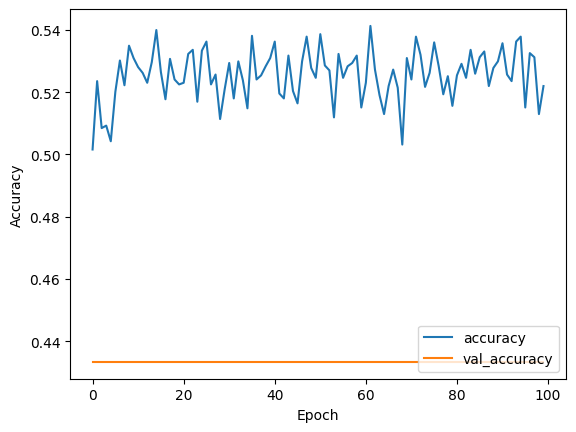

In [8]:
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# # model.summary()

hist = model.fit(
    train_x,
    train_y,
    epochs=100,
    validation_data=(test_x, test_y),
    # callbacks=[early_stopper],
    verbose=2,
)

import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

### Test on test data


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_x)

bin_preds = (preds > 0.5).astype(int)

accuracy = accuracy_score(test_y, bin_preds)
print(f"Accuracy: {accuracy}")

# Print confusion matrix
confusion_mat = confusion_matrix(test_y, bin_preds)
print("Confusion Matrix:")
print(
    pd.DataFrame(
        confusion_mat,
        columns=["Predicted Negative", "Predicted Positive"],
        index=["Actual Negative", "Actual Positive"],
    )
)

51/51 [==============================] - 31s 356ms/step
Accuracy: 0.43341553637484587
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 703                   0
Actual Positive                 919                   0


In [10]:
model.save("models/b2/without_pretrained_weights_model")

INFO:tensorflow:Assets written to: models/b2/without_pretrained_weights_model/assets


INFO:tensorflow:Assets written to: models/b2/without_pretrained_weights_model/assets
